In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
!pip3 install surprise

In [61]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict

In [119]:
movies = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/preprocessed_movielens_1m/movies.csv')
tags = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/preprocessed_movielens_1m/tags.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/preprocessed_movielens_1m/ratings.csv')
users = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/preprocessed_movielens_1m/users.csv')

movies = movies.iloc[: , 1:]
tags = tags.iloc[: , 1:]
ratings = ratings.iloc[: , 1:]
users = users.iloc[: , 1:]

In [120]:
main = pd.DataFrame(ratings)

# Feature 1: Content-Based Filtering 

Get all the movies that a user likes - and use content-based filtering to generate a list of similar movies that the user might also like 

The movies get grouped by analysing the tags associated with each movie (tags are a combination of user comments and movie genres)

Cast the columns in movies and tags

In [121]:
tags = tags.astype({'tags' : 'string'})
tags = tags.astype({'title' : 'string'})
tags = tags.astype({'genres' : 'string'})
tags.dtypes

movie_id     int64
tags        string
title       string
genres      string
year         int64
dtype: object

In [122]:
movies = movies.astype({'title' : 'string'})
movies = movies.astype({'genres' : 'string'})
movies.dtypes

movie_id     int64
title       string
genres      string
year         int64
dtype: object

In [123]:
# an example of a tag
tag_example = tags['tags'][0]
tag_example

"pixar pixar pixar animation pixar animated fun toy toys pixar rated g pixar pixar national film registry time travel pixar pixar funny imdb top  animation very good ya boy pixar time travel animation erlend s dvds cgi disney family pixar toys bright daring rescues fanciful heroic mission humorous light rousing toys come to life unlikely friendships warm witty pixar the boys almost favorite é ä é animation children disney pixar clever want to see again cartoon disney d computer animation disney animated feature pixar animation want buddy movie animation pixar tim allen tom hanks animation disney pixar toys computer animation cartoon pixar animation computer animation pixar toys tumey s to see again tumey s vhs classic disney engaging avi buy action figure action figures buzz lightyear cg animation toy toys woody disney pixar tim allen tom hanks animation pixar animation kids movie pixar tim allen time travel animation cgi adventure animation children comedy animation pixar lots of hear

In [124]:
# make sure that every movie has a tag
tags.isna().sum()

movie_id    0
tags        0
title       0
genres      0
year        0
dtype: int64

In [125]:
# how many ratings we have 
print(len(ratings['movie_id']))

# how many unique movies we have in ratings
movies_in_ratings = ratings['movie_id'].drop_duplicates()
print(len(movies_in_ratings))

1000209
3706


In [126]:
# it's redundant to draw information about movies that are not in the ratings df, so I will drop them 
print("Tags shape before dropping extra movies: " + str(tags.shape))
tags = tags[tags.movie_id.map(lambda x: np.isin(x, movies_in_ratings).all())]
print("Tags shape after dropping extra movies: " + str(tags.shape))
# drop any movie that we have twice
tags = tags.drop_duplicates(subset=['title'])
print("Tags shape after dropping duplicate movies: " + str(tags.shape))

Tags shape before dropping extra movies: (3883, 5)
Tags shape after dropping extra movies: (3706, 5)
Tags shape after dropping duplicate movies: (3664, 5)


## Content-Based Filtering Engine

In [127]:
tags = tags.reset_index()
tags = tags.drop(columns=['index'])
tags.tail()

,movie_id,tags,title,genres,year
3659,3948,ben stiller comedy hilarious owen wilson ben s...,Meet the Parents,comedy,2000
3660,3949,ass to ass heroin psychology depressing drugs ...,Requiem for a Dream,drama,2000
3661,3950,colin farrell drama drama drama drama drama,Tigerland,drama,2000
3662,3951,in netflix queue in netflix queue r drama dram...,Two Family House,drama,2000
3663,3952,politics vice president washington dc gary old...,"Contender, The",drama thriller,2000


When building the matrix, the issue is that since the length of the tags dataframe is not the same as the maximum index of movie in the dataframe

In [128]:
print("max movie id: " + str(tags['movie_id'].max()))
print("length of the tags dataframe: " + str(len(tags['movie_id'])))

max movie id: 3952
length of the tags dataframe: 3664


In [129]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
matrix = tf.fit_transform(tags['tags'])

cosine_similarities = linear_kernel(matrix,matrix)
movie_title = tags['title']
indices = pd.Series(tags.index, index=tags['title'])

def recommend_movies(original_title):

    idx = indices[original_title]
    sim_scores = list(enumerate(cosine_similarities[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:51]

    movie_indices = [i[0] for i in sim_scores]
    titles = movie_title.iloc[movie_indices]
    return titles, movie_indices

In [130]:
t, i  = recommend_movies('Clueless')
print(t)

27                                             Persuasion
2833                                       Mansfield Park
786                                                  Emma
16                                  Sense and Sensibility
62                                          Two if by Sea
113                                          If Lucy Fell
278                                    Nina Takes a Lover
285                                     Perez Family, The
286                            Pyromaniac's Love Story, A
368                                            Speechless
433                                            Favor, The
552                                     Naked in New York
761       Rendezvous in Paris (Rendez-vous de Paris, Les)
1341                        Beautician and the Beast, The
1343                                        Hotel de Love
1349                                     That Old Feeling
1353                                           Booty Call
1422          

Clueless is based on 'Emma' by Jane Austen, Persuasion is also a Jane Austen book, therefore I think CBF works quite well :) 

## Generate similar movies

In [131]:
# any movies in ratings that we don't have tags for? 
print(list(set(ratings['movie_id']) - set(tags['movie_id'])))
movies_in_tags = tags['movie_id'].drop_duplicates()

[2561, 2820, 2565, 2059, 3723, 3598, 915, 1941, 2455, 3096, 2078, 2719, 2848, 3616, 3744, 2212, 2085, 2729, 1460, 3126, 2364, 957, 2367, 1344, 3784, 2633, 2634, 2764, 3404, 3022, 2512, 1873, 2389, 2645, 2135, 2136, 2398, 3935, 3947, 3823, 2553, 2430]


for each movie in ratings, generate a list of n similar movies

In [132]:
similar_movies_map = {} 
no_similar_movies_count = 0

# getting rid of any movies we don't have tags for 
movies_in_ratings = list(set(movies_in_ratings) and set(movies_in_tags))

for movie in movies_in_ratings: 
  title = str(tags[tags['movie_id'] == movie]['title'].values[0])
  # actual_index = tags.index[tags['movie_id'] == movie]
  t, ind = recommend_movies(title)
  similar_movies_map[movie] = ind;
  if (len(ind) == 0): 
    no_similar_movies_count += 1

print("No similar movies found for " + str(no_similar_movies_count) + " movies")

No similar movies found for 0 movies


## Add feature to dataframe

get favourite movies by each user

In [133]:
#  get movies that users rated positively 
positive_ratings = pd.DataFrame()
positive_ratings['user_id'] = users['user_id']

In [134]:
positive_ratings['movies'] = None

for index, row in positive_ratings.iterrows():
    user = int(row['user_id'])
    # get a list of movies that the user rated with 4 or 5
    rated_movies = list(ratings.loc[(ratings['user_id'] == user) & (ratings['rating'] >= 3)]['movie_id'].values)
    positive_ratings.at[index, 'movies'] = rated_movies


In [135]:
positive_ratings.head()

,user_id,movies
0,1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,..."
1,2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,..."
2,3,"[3421, 648, 1394, 3534, 104, 2735, 1210, 1431,..."
3,4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,..."
4,5,"[2987, 2333, 1175, 39, 2337, 1535, 1392, 1466,..."


In [136]:
positive_ratings['CBF'] = None
count = 0
for index, row in positive_ratings.iterrows(): 
    if (index % 1000 == 0): 
        print(index)
    rated_movies = list(row['movies'])
    all_similar_movies = []
    # for each movie that the user likes 
    for movie in rated_movies: 
        # get similar movies and add the
        similar_movies = similar_movies_map.get(int(movie))
        if (similar_movies != None): 
            all_similar_movies += similar_movies 
    positive_ratings.at[index, 'CBF'] = all_similar_movies

0
1000
2000
3000
4000
5000
6000


In [137]:
positive_ratings.head()

,user_id,movies,CBF
0,1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...","[844, 1755, 1772, 1750, 1756, 1752, 1744, 1748..."
1,2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...","[911, 2233, 126, 176, 484, 598, 660, 736, 922,..."
2,3,"[3421, 648, 1394, 3534, 104, 2735, 1210, 1431,...","[1128, 315, 3054, 3196, 2561, 1203, 2562, 342,..."
3,4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...","[2263, 2822, 81, 178, 1495, 274, 26, 29, 88, 1..."
4,5,"[2987, 2333, 1175, 39, 2337, 1535, 1392, 1466,...","[1106, 575, 466, 1108, 253, 1909, 1817, 709, 1..."


Add a new feature 'CBF' which will have binary values 


*   1 - this movie is in the list of recommended movies generated by the content based filtering algorithm
*   0 - this movie is not in the list of recommended movies generated by the content based filtering algorithm



In [138]:
# set CBF as 0 by default 
main['CBF'] = 0
main.head()

,user_id,movie_id,rating,CBF
0,1,1193,5,0
1,1,661,3,0
2,1,914,3,0
3,1,3408,4,0
4,1,2355,5,0


In [139]:
counter = 0

for index, row in main.iterrows(): 
  if (index % 100000 == 0): 
    print(index)
  user = int(row['user_id'])
  movie = int(row['movie_id'])

  movies_recommended_for_user = list(positive_ratings[positive_ratings['user_id'] == user]['CBF'])
  if (movie in movies_recommended_for_user):
    main.at[index, 'CBF'] = 1
    counter += 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [140]:
print(counter)

0


In [31]:
main.head()

,user_id,movie_id,rating,CBF
0,1,1193,5,0
1,1,661,3,0
2,1,914,3,0
3,1,3408,4,0
4,1,2355,5,0


In [32]:
main['CBF'].value_counts()

0    1000209
Name: CBF, dtype: int64

# Feature 2: Collaborative Filtering

predict the rating for each movie with collaborative filtering

## Collaborative Filtering Engine

In [141]:
reader = Reader()
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv = 10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8663  0.8647  0.8673  0.8681  0.8635  0.8680  0.8647  0.8605  0.8627  0.8630  0.8649  0.0024  
MAE (testset)     0.6793  0.6778  0.6800  0.6810  0.6779  0.6803  0.6779  0.6756  0.6761  0.6783  0.6784  0.0017  
Fit time          70.67   58.01   55.46   53.28   53.08   54.12   52.74   52.55   53.54   55.93   55.94   5.17    
Test time         0.86    0.78    0.74    0.72    0.73    0.72    0.72    0.73    0.75    0.72    0.75    0.04    


{'test_rmse': array([0.86628605, 0.86468544, 0.86729641, 0.86812217, 0.86354245,
        0.86797425, 0.86469706, 0.86046201, 0.86273841, 0.86304438]),
 'test_mae': array([0.679251  , 0.67778072, 0.67998035, 0.68104684, 0.67785587,
        0.68030259, 0.67790047, 0.67564052, 0.67608296, 0.67829314]),
 'fit_time': (70.66683793067932,
  58.006356954574585,
  55.46218299865723,
  53.28081679344177,
  53.0758421421051,
  54.118653297424316,
  52.73518991470337,
  52.55186200141907,
  53.53822183609009,
  55.927162885665894),
 'test_time': (0.8640508651733398,
  0.776298999786377,
  0.737015962600708,
  0.7214748859405518,
  0.7293257713317871,
  0.7199299335479736,
  0.7188959121704102,
  0.725121021270752,
  0.7538390159606934,
  0.7232069969177246)}

In [142]:
trainset = data.build_full_trainset()
svd.fit(trainset)
testset = trainset.build_anti_testset()
predictions = svd.test(testset)

In [143]:
def predict_rating_CF(user_id, movie_id, true_rating): 
  return svd.predict(user_id, movie_id, true_rating)

In [144]:
main['CF'] = 0

for index, row in main.iterrows():
    user = row['user_id']
    movie = row['movie_id']
    rating = row['rating']
    predicted_rating = predict_rating_CF(user, movie, rating)
    predicted_rating = predicted_rating[3]
    
    main.at[index,'CF'] = predicted_rating

In [145]:
main.head()

,user_id,movie_id,rating,CBF,CF
0,1,1193,5,0,4
1,1,661,3,0,3
2,1,914,3,0,4
3,1,3408,4,0,4
4,1,2355,5,0,4


# Feature 3: Age at Rating

how old was the user when they left the rating on the movie

In [146]:
main['age_when_rating'] = 0

for index, row in main.iterrows(): 
  user = int(row['user_id'])
  user_in_users = users[users['user_id'] == user]
  user_age = user_in_users['age'].values
  main.at[index, 'age_when_rating'] = int(user_age)

main.tail()

,user_id,movie_id,rating,CBF,CF,age_when_rating
1000204,6040,1091,1,0,1,25
1000205,6040,1094,5,0,3,25
1000206,6040,562,5,0,3,25
1000207,6040,1096,4,0,3,25
1000208,6040,1097,4,0,3,25


In [147]:
print("mean: " + str(main['age_when_rating'].mean()))
print("median: " + str(main['age_when_rating'].median()))

mean: 29.73831369243828
median: 25.0


{'whiskers': [<matplotlib.lines.Line2D at 0x123a2e810>,
 'caps': [<matplotlib.lines.Line2D at 0x123b72b90>,
 'boxes': [<matplotlib.lines.Line2D at 0x123a2e0d0>],
 'medians': [<matplotlib.lines.Line2D at 0x3b048e510>],
 'fliers': [<matplotlib.lines.Line2D at 0x3b02e1810>],
 'means': []}

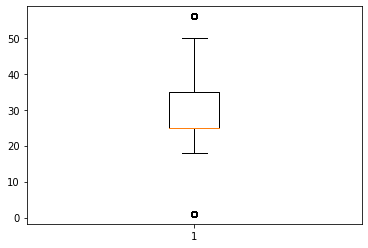

In [148]:
fig,ax = plt.subplots()
ax.boxplot(main['age_when_rating'])

# Feature 4: Age at Release 

how old was the user when the movie came out

In [149]:
main['age_at_release'] = 0

for index, row in main.iterrows(): 
  user = int(row['user_id'])
  movie = int(row['movie_id'])
  user_in_users = users[users['user_id'] == user]
  user_age = user_in_users['age'].values
  movie_release_year = movies[movies['movie_id'] == movie]
  movie_release_year = movie_release_year['year']
  movie_release_year = movie_release_year.values
  user_birth_year = 1998 - user_age
  age_at_release = movie_release_year - user_birth_year
  main.at[index, 'age_at_release'] = int(age_at_release)

main.tail()

,user_id,movie_id,rating,CBF,CF,age_when_rating,age_at_release
1000204,6040,1091,1,0,1,25,16
1000205,6040,1094,5,0,3,25,19
1000206,6040,562,5,0,3,25,22
1000207,6040,1096,4,0,3,25,9
1000208,6040,1097,4,0,3,25,9


In [150]:
main.head()

,user_id,movie_id,rating,CBF,CF,age_when_rating,age_at_release
0,1,1193,5,0,4,1,-22
1,1,661,3,0,3,1,-1
2,1,914,3,0,4,1,-33
3,1,3408,4,0,4,1,3
4,1,2355,5,0,4,1,1


# Feature 5: Released after birth

Was the movie released after the user was born. 1 - yes, 2 - no

In [151]:
main['released_after_birth'] = 0 

for index, row in main.iterrows(): 
    age_at_release = int(row['age_at_release'])
    if (age_at_release >= 0): 
        main.at[index, 'released_after_birth'] = 1

# Feature 6: Gender

In [152]:
main['gender'] = None

for index, row in main.iterrows(): 
  user = int(row['user_id'])
  user_in_users = users[users['user_id'] == user]
  user_gender = int(user_in_users['gender'].values)
  main.at[index, 'gender'] = user_gender

main.tail()

,user_id,movie_id,rating,CBF,CF,age_when_rating,age_at_release,released_after_birth,gender
1000204,6040,1091,1,0,1,25,16,1,0
1000205,6040,1094,5,0,3,25,19,1,0
1000206,6040,562,5,0,3,25,22,1,0
1000207,6040,1096,4,0,3,25,9,1,0
1000208,6040,1097,4,0,3,25,9,1,0


In [83]:
main.describe()

,user_id,movie_id,rating,CBF,CF,age_when_rating,age_at_release,released_after_birth
count,1.000209e+06,1.000209e+06,1.000209e+06,1000209.0,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,0.0,3.083962e+00,2.973831e+01,1.843672e+01,8.872976e-01
std,1.728413e+03,1.096041e+03,1.117102e+00,0.0,8.144378e-01,1.175198e+01,1.697263e+01,3.162289e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,-7.600000e+01,0.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,0.0,3.000000e+00,2.500000e+01,1.100000e+01,1.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00,0.0,3.000000e+00,2.500000e+01,2.000000e+01,1.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00,0.0,4.000000e+00,3.500000e+01,2.700000e+01,1.000000e+00
max,6.040000e+03,3.952000e+03,5.000000e+00,0.0,5.000000e+00,5.600000e+01,5.800000e+01,1.000000e+00


# Feature 7: Favourite Genre

What is the favourite genre of each user

In [154]:
movies.head()

,movie_id,title,genres,year
0,1,Toy Story,animation children's comedy,1995
1,2,Jumanji,adventure children's fantasy,1995
2,3,Grumpier Old Men,comedy romance,1995
3,4,Waiting to Exhale,comedy drama,1995
4,5,Father of the Bride Part II,comedy,1995


In [188]:
genres = movies.copy(deep=True)

In [189]:
genres['genres'].value_counts()

drama                              843
comedy                             521
horror                             178
comedy drama                       162
comedy romance                     142
                                  ... 
horror mystery                       1
musical romance war                  1
adventure animation film-noir        1
adventure animation sci-fi           1
adventure crime sci-fi thriller      1
Name: genres, Length: 301, dtype: Int64

In [190]:
genres_map = {'drama': 0,
              'comedy' : 1, 
              'action' : 2, 
              'thriller': 3,
              'romance': 4, 
              'horror': 5, 
              'adventure': 6,
              'sci-fi': 7,
              'children\'s': 8,
              'crime': 9,
              'war': 10,
              'documentary': 11, 
              'musical': 12,
              'mystery': 13,
              'animation': 14,
              'fantasy': 15,
              'western': 16, 
              'film_noir': 17,
              }

In [191]:
def encode_genres(genres): 
    encoded = '' 
    words = ''
    if (genres != None):
        words = genres.split()
    encoded = []
    for word in words: 
        index = genres_map.get(word)
        encoded.append(index)
    
    return encoded

In [192]:
genres

,movie_id,title,genres,year
0,1,Toy Story,animation children's comedy,1995
1,2,Jumanji,adventure children's fantasy,1995
2,3,Grumpier Old Men,comedy romance,1995
3,4,Waiting to Exhale,comedy drama,1995
4,5,Father of the Bride Part II,comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents,comedy,2000
3879,3949,Requiem for a Dream,drama,2000
3880,3950,Tigerland,drama,2000
3881,3951,Two Family House,drama,2000


In [193]:
genres['encoded'] = None

In [194]:
for index, row in genres.iterrows():
    genres_str = row['genres']
    genres_list = encode_genres(genres_str)
    genres.at[index, 'encoded'] = genres_list

In [195]:
genres.head()

,movie_id,title,genres,year,encoded
0,1,Toy Story,animation children's comedy,1995,"[14, 8, 1]"
1,2,Jumanji,adventure children's fantasy,1995,"[6, 8, 15]"
2,3,Grumpier Old Men,comedy romance,1995,"[1, 4]"
3,4,Waiting to Exhale,comedy drama,1995,"[1, 0]"
4,5,Father of the Bride Part II,comedy,1995,[1]


In [163]:
positive_ratings.head()

,user_id,movies,CBF
0,1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...","[844, 1755, 1772, 1750, 1756, 1752, 1744, 1748..."
1,2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...","[911, 2233, 126, 176, 484, 598, 660, 736, 922,..."
2,3,"[3421, 648, 1394, 3534, 104, 2735, 1210, 1431,...","[1128, 315, 3054, 3196, 2561, 1203, 2562, 342,..."
3,4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...","[2263, 2822, 81, 178, 1495, 274, 26, 29, 88, 1..."
4,5,"[2987, 2333, 1175, 39, 2337, 1535, 1392, 1466,...","[1106, 575, 466, 1108, 253, 1909, 1817, 709, 1..."


In [169]:
# generate a list of genres 

positive_ratings['genres'] = None 

for index, row in positive_ratings.iterrows(): 
    favourite_movies = list(row['movies'])
    favourite_genres = []
    for movie in favourite_movies: 
        movie_genres = list(genres[genres['movie_id'] == movie]['encoded'])
        if (movie_genres != None): 
            favourite_genres += movie_genres
    positive_ratings.at[index, 'genres'] = favourite_genres
        

In [171]:
positive_ratings['genres']

0       [[0], [14, 8, 12], [12, 4], [0], [14, 8, 1], [...
1       [[0, 4], [0], [1], [0, 10], [2, 9, 0], [2, 6, ...
2       [[1], [2, 6, 13], [1], [1], [1], [2, 6, 1], [2...
3       [[0], [2, 6, 4, 7, 10], [2, 16], [2, 5, 7, 3],...
4       [[6, 14, None], [0], [1, 7], [1, 4], [0], [0, ...
                              ...                        
6035    [[0], [1, 0], [6, 8, 1, 15, 7], [2, 7, 3], [2,...
6036    [[2, 7, 3], [0], [5, 3], [1, 11], [1, 0, 4], [...
6037    [[0], [0, 4, 10], [1], [1, 0], [1], [14, 1], [...
6038    [[14, 8, 1, 12], [0, 4, 10], [0, 12], [1], [1]...
6039    [[0], [2, 7, 3], [14, 8, 1], [0], [0, 3], [0],...
Name: genres, Length: 6040, dtype: object

In [180]:
import collections 

def get_favourites(genres): 
    all_genres = []
    for list_of_genres in genres: 
        all_genres += list_of_genres
    
    counter  = collections.Counter(all_genres)
    top_3_with_count = counter.most_common(3)
    top_3 = []
    for keyval in top_3_with_count: 
        key = keyval[0]
        top_3 += [key]
    return top_3
    # now we have a list of all the genres for all the favourite movies
    # try to get top 3 
    
    

In [183]:
positive_ratings['favourites'] = None
for index, row in positive_ratings.iterrows(): 
    genres = row['genres']
    favourites = get_favourites(genres)
    positive_ratings.at[index, 'favourites'] = favourites 

In [184]:
positive_ratings['favourites']

0       [0, 8, 14]
1        [0, 2, 3]
2        [1, 6, 2]
3        [2, 7, 0]
4        [0, 1, 4]
           ...    
6035     [0, 1, 4]
6036     [0, 3, 1]
6037     [1, 0, 4]
6038    [1, 12, 4]
6039     [0, 1, 3]
Name: favourites, Length: 6040, dtype: object

In [216]:
def has_intersection(list1, list2): 
    list1 = list1[0]
    list2 = list2[0]
    for item in list1: 
        if item in list2: 
            return True
    return False

In [217]:
# check if each movie is of the user's favourite genre 

main['is_favourite_genre'] = 0
for index, row in main.iterrows(): 
    if (index % 100000 == 0): 
        print(index)
    user = row['user_id']
    movie = row['movie_id']
    user_favourite_genres = positive_ratings[positive_ratings['user_id'] == user]['favourites']
    movie_genres = genres[genres['movie_id'] == movie]['encoded']
    
    if (has_intersection(movie_genres.values, user_favourite_genres.values)): 
        main.at[index, 'is_favourite_genre'] = 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [218]:
main['is_favourite_genre'].value_counts()

1    828608
0    171601
Name: is_favourite_genre, dtype: int64

In [219]:
main.head()

,user_id,movie_id,rating,CBF,CF,age_when_rating,age_at_release,released_after_birth,gender,is_favourite_genre
0,1,1193,5,0,4,1,-22,0,1,1
1,1,661,3,0,3,1,-1,0,1,1
2,1,914,3,0,4,1,-33,0,1,0
3,1,3408,4,0,4,1,3,1,1,1
4,1,2355,5,0,4,1,1,1,1,1


# Feature 8: imdb rating

In [221]:
imdb_ratings = pd.read_csv("title.ratings.tsv", sep='\t')

In [222]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1864
1,tt0000002,6.0,244
2,tt0000003,6.5,1632
3,tt0000004,5.8,158
4,tt0000005,6.2,2458


In [223]:
imdb_titles = pd.read_csv("title.basics.tsv", sep='\t')

/Users/nutsa/.pyenv/versions/3.7.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [226]:
imdb_titles= imdb_titles[imdb_titles['titleType']=='movie']

In [ ]:
imdb_titles['startYear'].max()

In [227]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama
